In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models
from epam.torch_common import pick_device, parameter_count_of_model

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nickname = 'small'

max_length=500
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [5]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    model_file_path = f"../weights/{model_name}.pt"
    best_val_loss = None

    if os.path.exists(model_file_path):
        print(f"\tLoading pre-trained {model_name}...")
        model_instance.load_state_dict(torch.load(model_file_path))
        model_instance.eval()  # Set model to evaluation mode
        if "cnn" in model_name:
            train_dataset.to(device)
            val_dataset.to(device)
            model_instance.to(device)
        burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
        best_val_loss = burrito.evaluate()
    else:
        print(f"\tTraining {model_name}...")
        if "cnn" in model_name:
            train_dataset.to(device)
            val_dataset.to(device)
            model_instance.to(device)
        burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
        
        train_history = burrito.train(epochs=epochs)
        best_val_loss = train_history['val_loss'].min()
        # save model to weights/ directory
        Path("../weights").mkdir(parents=True, exist_ok=True)
        torch.save(model_instance.state_dict(), model_file_path)

    result = {'model_name': model_name, 'model': str(model_instance), 'parameter_count': parameter_count_of_model(model_instance), 'val_loss': best_val_loss}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

train_dataset_3, val_dataset_3 = data_of_nickname(val_nickname, kmer_length=3)
train_dataset_5, val_dataset_5 = data_of_nickname(val_nickname, kmer_length=5)
    
model_instances_3 = {
    "cnn_sml": models.CNNModel(train_dataset_3, embedding_dim=6, num_filters=14, kernel_size=7, dropout_rate=0.0),
    "cnn_med": models.CNNModel(train_dataset_3, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1),
    "cnn_lrg": models.CNNModel(train_dataset_3, embedding_dim=7, num_filters=19, kernel_size=11, dropout_rate=0.3),
    "cnn_4k": models.CNNModel(train_dataset_3, embedding_dim=12, num_filters=14, kernel_size=17, dropout_rate=0.1),
    "cnn_8k": models.CNNModel(train_dataset_3, embedding_dim=14, num_filters=25, kernel_size=15, dropout_rate=0.0),
    }

model_instances_5 = {
    "fivemer": models.FivemerModel(train_dataset_5),
    "shmoof": models.SHMoofModel(train_dataset_5),
}
    
comparison_df = \
    pd.concat([ comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)
            ])
comparison_df["val_nickname"] = val_nickname

comparison_df
    

	Loading pre-trained cnn_sml...
	Loading pre-trained cnn_med...
	Loading pre-trained cnn_lrg...
	Loading pre-trained cnn_4k...
	Training cnn_8k...


Epoch:  29%|██▉       | 29/100 [04:39<11:25,  9.65s/it, loss_diff=4.935e-07, lr=3.2e-5]  

	Loading pre-trained fivemer...
	Loading pre-trained shmoof...


,model_name,model,parameter_count,val_loss,val_nickname
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.055603,small
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.055513,small
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.055402,small
3,cnn_4k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",3665,0.055367,small
4,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.055544,small
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055730,small
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.055601,small


In [6]:
tang_df = pd.read_csv("/Users/matsen/data/tang-deepshm_size2_edges_22-May-2023.branch_length.csv", index_col=0).reset_index(drop=True)

# only keep rows where parent is different than child
tang_df = tang_df[tang_df["parent"] != tang_df["child"]]
tang_dataset_3 = framework.SHMoofDataset(tang_df, kmer_length=3, max_length=max_length)
tang_dataset_5 = framework.SHMoofDataset(tang_df, kmer_length=5, max_length=max_length)
tang_dataset_3.to(device)
tang_dataset_5.to(device)

In [7]:
def calculate_loss(model, dataset):
    model.eval()
    model.to(device)
    burrito = framework.Burrito(dataset, dataset, model, verbose=False, **burrito_params)
    loss = burrito.evaluate()
    return loss

comparison_df["tang_loss"] = None
for model_name, model_instance in model_instances_3.items():
    comparison_df.loc[comparison_df["model_name"] == model_name, "tang_loss"] = calculate_loss(model_instance, tang_dataset_3)

for model_name, model_instance in model_instances_5.items():
    comparison_df.loc[comparison_df["model_name"] == model_name, "tang_loss"] = calculate_loss(model_instance, tang_dataset_5)

In [8]:
comparison_df

,model_name,model,parameter_count,val_loss,val_nickname,tang_loss
0,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.055603,small,0.089995
1,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.055513,small,0.089602
2,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.055402,small,0.0894
3,cnn_4k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",3665,0.055367,small,0.089619
4,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.055544,small,0.089904
0,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.055730,small,0.089921
1,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.055601,small,0.09028


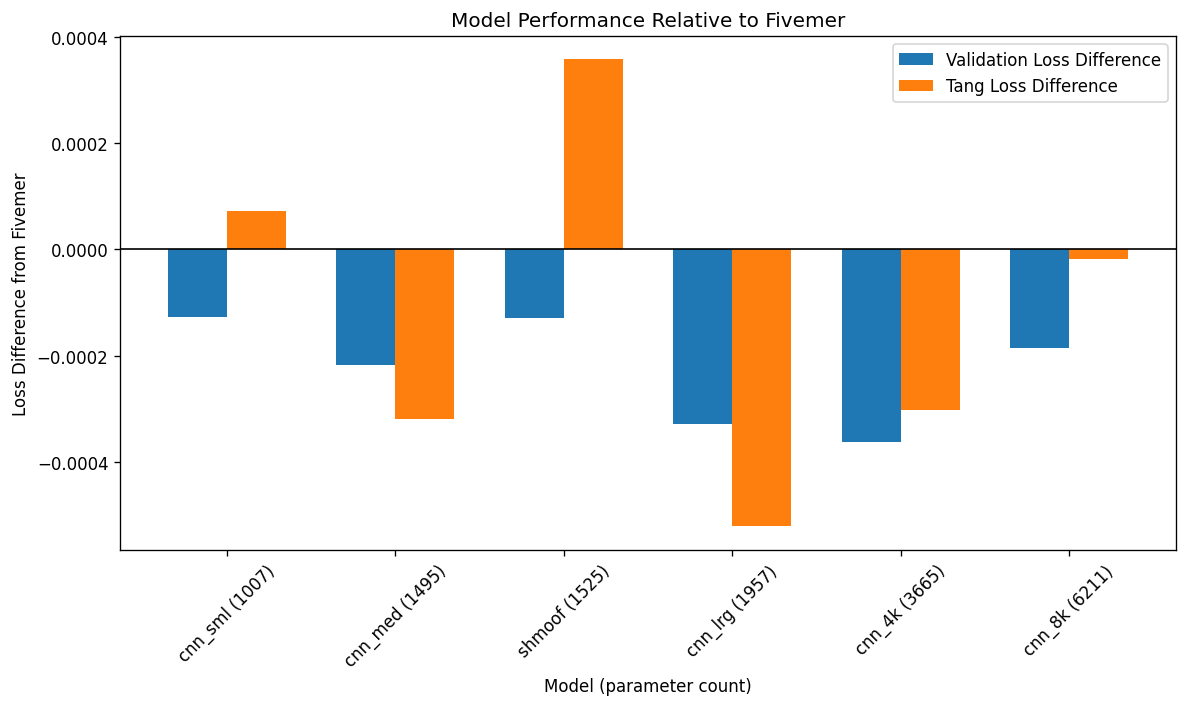

In [9]:
# Your DataFrame
df = comparison_df

# Calculate the difference from the fivemer model for val_loss and tang_loss
fivemer_val_loss = df[df['model_name'] == 'fivemer']['val_loss'].values[0]
fivemer_tang_loss = df[df['model_name'] == 'fivemer']['tang_loss'].values[0]

df['val_loss_diff'] = df['val_loss'] - fivemer_val_loss
df['tang_loss_diff'] = df['tang_loss'] - fivemer_tang_loss

# Filter out the fivemer model and sort by parameter count
df = df[df['model_name'] != 'fivemer']
df = df.sort_values(by='parameter_count')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(df))

# Creating offset for the second bar
offset = bar_width / 2

bar1 = ax.bar(index - offset, df['val_loss_diff'], bar_width, label='Validation Loss Difference')
bar2 = ax.bar(index + offset, df['tang_loss_diff'], bar_width, label='Tang Loss Difference')

ax.set_xlabel('Model (parameter count)')
ax.set_ylabel('Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.legend()
ax.axhline(0, color='black', linewidth=1)  # Add x-axis line

# Format x-axis labels with model names and parameter counts
x_labels = [f"{row['model_name']} ({row['parameter_count']})" for _, row in df.iterrows()]
plt.xticks(index, x_labels, rotation=45)

plt.tight_layout()
plt.show()